# How to read in and interpret Level 2 SIF data
This jupyter notebook will guide you how to use SIF Level 2 data (ungridded SIF retrievals for each individual satellite footprint) in your research. I will also go through some of the typical pitfalls and misconceptions in using the data. The examples will be based mostly on TROPOMI and OCO-2 data but can easily be adapted to also access GOME-2 and SCIAMACHY data. In fact, some of the provided readers will be easily adaptable to ingest any arbitrary Level 2 dataset in HDF5 (or netCDF4).

### Goals:
<li> Learn how to read in OCO-2 and TROPOMI data
<li> Learn that noise is normal and well characterized by the retrievals
<li> Extract data from specific regions and create time-series
<li> Learn how convert measurements at different wavelengths and times of day.

### Data format:
First of all, almost all scientific datasets are now provided in either HDF or netCDF formats. We currently use the latest standards, i.e. HDF5 and netCDF4 (which is basically a layer on top of HDF5, so any HDF5 reader can access netCDF datasets). Typically, datasets include comments and units as attributes, so that you know what you are dealing with even without a user guide. In python, there are very convenient tools to access these files, h5py (http://docs.h5py.org/en/stable/) and netCDF4 (http://unidata.github.io/netcdf4-python/). A good start to look at files in the beginning is to use viewing tools like:
<li> hdfview: https://support.hdfgroup.org/products/java/hdfview/
<li> panoply (great for actually viewing L3 files!): https://www.giss.nasa.gov/tools/panoply/
<li> you should also be able to use ncl tools: https://www.ncl.ucar.edu/ (not too familiar myself with those)


Setting up the Jupyter environment (typical imports)

In [1]:
#%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
import matplotlib.pyplot as plt
import numpy as np
# nicer figures using ggg plot style.
plt.style.use('ggplot')
from IPython.core.display import HTML
from IPython.display import clear_output
from IPython.core.pylabtools import figsize


### Most important step, import all tools in the L2_tools.py file 
(take a look at this if you want to know what is under the hood)

In [31]:
# This file L2_tools.py is in the same folder here and will provide easy access to TROPOMI and OCO-2 L2 data 
from L2_tools import *

### Download data first:
paths for OCO-2 and TROPOMI data (in fact, the path just points to our internal structure of the ftp server at 
ftp://fluo.gps.caltech.edu/data/). So once you copy the folders (I suggest you learn how to use wget https://www.gnu.org/software/wget/ or curl https://www.tecmint.com/linux-curl-command-examples/)


In [3]:
# Please adapt to your local directories after having mirrored our ftp data (and extracted the ungridded TROPOMI files):
path_tropomi = '/Volumes/data2/projects/TROPOMI/nc_ungridded/'
path_oco2 = '/Volumes/data1/ftp/data/OCO2/sif_lite_B8100/'

# This is still cumbersome, the units are part of the netCDF4 files but I hardcode them for now:
t_unit_oco2    = "seconds since 1993-1-1 0:0:0"
t_unit_tropomi = "seconds since 1970-01-01 00:00:00"
t_cal = u"gregorian"

In [4]:
# Let us read in some OCO-2 and TROPOMI data over a non-fluorescing region in the Sahara
# Define region boundaries for a part of the Sahara:
latMin = 20
latMax = 25
lonMin = 5
lonMax = 15

Now read in the data, two dictionaries for OCO-2 and TROPOMI were included in L2_tools.py, it basically just enables you to decides which fields to read in and can be adapted (actually to read in any kind of data)
The first entry should provide a path to all files you want to read (you can use wildcard!)

In [5]:
oco2_sahara = L2(path_oco2+'2018/0[45678]/*.nc4', dict_oco2,latMin, latMax, lonMin, lonMax )

In [6]:
# TROPOMI will take a bit more time, be patient!
tropomi_sahara = L2(path_tropomi+'*2018-0[45678]*.nc', dict_tropomi,latMin, latMax, lonMin, lonMax )

The syntax for reading in data is as follows:
data = L2(path_to_data, dictionary,latMin, latMax, lonMin, lonMax )
Find some examples for the dictionary below (these can be adapted to read in GOME-2 data). The format describes the "key" as how you want to name the variable in your returned class and the "item" as the variable name of the HDF5 file. 

------
Take a sneak peak at the dictionaries used, they basically describe which variable to read in (2nd componend) and how to call them in the class structure (first component)

In [7]:
dict_oco2

{'lat': 'latitude',
 'lon': 'longitude',
 'sza': 'solar_zenith_angle',
 'vza': 'sensor_zenith_angle',
 'saa': 'solar_azimuth_angle',
 'vaa': 'sensor_azimuth_angle',
 'biome': 'IGBP_index',
 'mode': 'measurement_mode',
 'sif_757': 'SIF_757nm',
 'sif_771': 'SIF_771nm',
 'sif_757_sigma': 'SIF_757nm_uncert',
 'sif_771_sigma': 'SIF_771nm_uncert',
 'dcCorr': 'daily_correction_factor',
 'time': 'time'}

In [8]:
dict_tropomi

{'lat': 'lat',
 'lon': 'lon',
 'sza': 'sza',
 'vza': 'vza',
 'phaseAngle': 'phase_angle',
 'sif': 'sif',
 'sif_sigma': 'sif_err',
 'dcCorr': 'daily_correction_factor',
 'time': 'TIME'}

In [9]:
# First convert oco2 time units to a python time (this is a clunky step right now, need to automate later!)
oco2_sahara.time_python    = convert_time(oco2_sahara.time, t_unit_oco2, t_cal)
tropomi_sahara.time_python = convert_time(tropomi_sahara.time, t_unit_tropomi, t_cal)

Text(0.5,1,'TROPOMI (SIF at 740nm)')

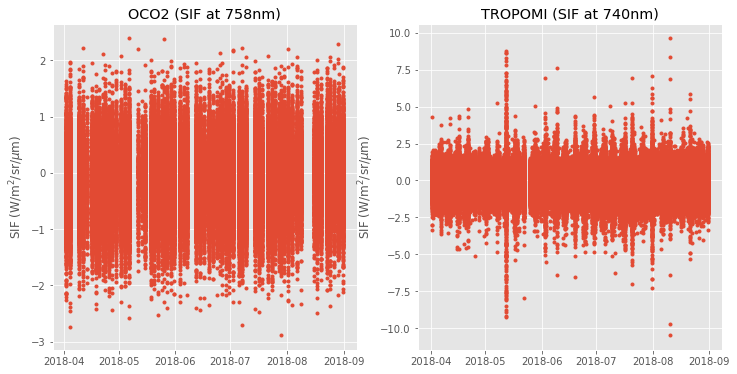

In [10]:
# now lets plot a timeseries
figsize(12,6)
plt.subplot(1,2,1)
plt.plot(oco2_sahara.time_python, oco2_sahara.sif_757,'.')
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.title('OCO2 (SIF at 758nm)')
plt.subplot(1,2,2)
plt.plot(tropomi_sahara.time_python, tropomi_sahara.sif,'.')
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.title('TROPOMI (SIF at 740nm)')

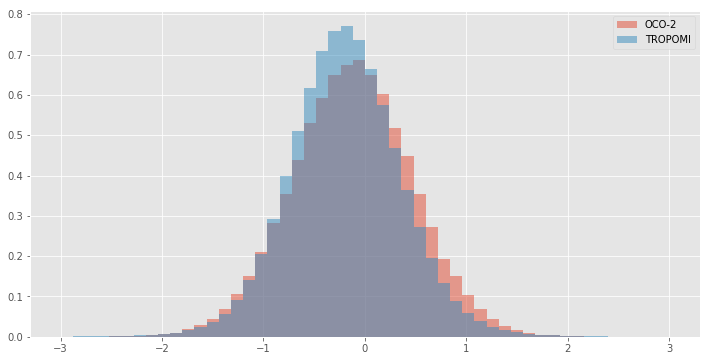

In [11]:
# let us look at a histogram
plt.hist(oco2_sahara.sif_757, 50,range=(-3,3), density=True, alpha=0.5, label='OCO-2')
plt.hist(tropomi_sahara.sif,  50,range=(-3,3), density=True, alpha=0.5, label='TROPOMI')
plt.legend(loc=0)

## Does this make sense?
We looked at the Sahara and SIF should be around 0. The data looks very noisy, can we make use of that? Many users ask us what to do with negative data, this example will show you why it is dangerous to exclude negative data in SIF the SIF analysis

In [12]:
print('Standard deviation of measured OCO-2 SIF data in Sahara ' + str(np.std(oco2_sahara.sif_757)) )
print('Expected standard deviation based on posteriori error ' + str(np.mean(oco2_sahara.sif_757_sigma)) )

Standard deviation of measured OCO-2 SIF data in Sahara 0.592667
Expected standard deviation based on posteriori error 0.494875


## Let's take a region with more SIF, e.g. the corn belt (roughly Iowa)


In [13]:
# Define region boundaries (roughly Iowa)
latMin_cb = 40
latMax_cb = 43
lonMin_cb = -96
lonMax_cb = -91

In [14]:
oco2_iowa = L2(path_oco2+'2018/0[45678]/*.nc4', dict_oco2,latMin_cb, latMax_cb, lonMin_cb, lonMax_cb )

In [15]:
tropomi_iowa = L2(path_tropomi+'*2018-0[45678]*.nc', dict_tropomi,latMin_cb, latMax_cb, lonMin_cb, lonMax_cb )

In [16]:
oco2_iowa.time_python    = convert_time(oco2_iowa.time, t_unit_oco2, t_cal)
tropomi_iowa.time_python = convert_time(tropomi_iowa.time, t_unit_tropomi, t_cal)

Text(0.5,1,'TROPOMI (SIF at 740nm)')

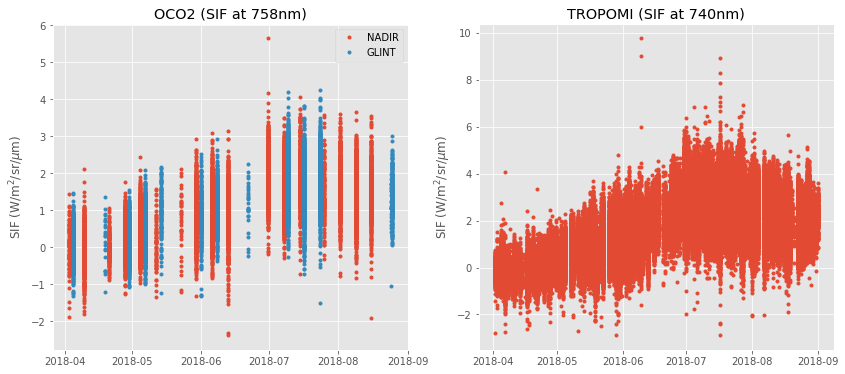

In [17]:
# now lets plot a timeseries
figsize(14,6)
plt.subplot(1,2,1)
nadir = np.where(oco2_iowa.mode==0)[0]
glint = np.where(oco2_iowa.mode==1)[0]
plt.plot(oco2_iowa.time_python[nadir], oco2_iowa.sif_757[nadir],'.', label='NADIR')
plt.plot(oco2_iowa.time_python[glint], oco2_iowa.sif_757[glint],'.', label='GLINT')
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.title('OCO2 (SIF at 758nm)')
plt.legend(loc=0)
plt.subplot(1,2,2)
plt.plot(tropomi_iowa.time_python, tropomi_iowa.sif,'.')
plt.ylabel('SIF (W/m$^2$/sr/$\mu$m)')
plt.title('TROPOMI (SIF at 740nm)')

Text(0.5,1,'TROPOMI time-series with PhaseAngle color-coded')

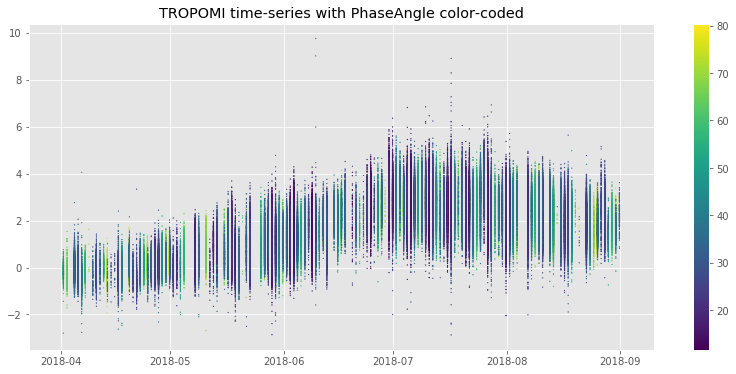

In [18]:
plt.scatter(tropomi_iowa.time_python, tropomi_iowa.sif,s=0.5, c=np.abs(tropomi_iowa.phaseAngle))
plt.colorbar()
plt.title('TROPOMI time-series with PhaseAngle color-coded')

In [19]:
print('Number of OCO-2 data points in Iowa:   ' + str(len(oco2_iowa.sif_757)))
print('Number of TROPOMI data points in Iowa: ' + str(len(tropomi_iowa.sif)))

Number of OCO-2 data points in Iowa:   17973
Number of TROPOMI data points in Iowa: 265885


In [20]:
# Let us define some averaging interval, get data every 3 days and create a running mean of +/- 3 days:
from datetime import datetime
# Define data range to smooth on (every 3 days)
dates = np.arange('2018-04', '2018-08', dtype='datetime64[3D]').astype(datetime)

## Let us compute timeseries from OCO-2 and TROPOMI data

In [21]:
# We used dates with a 3 day time-step and now use a +/- 3 day filter for the running mean:
iowa_timeseries_oco2 =    sif_rMean(oco2_iowa.time_python, oco2_iowa.sif_757,dates, 3 )
iowa_timeseries_tropomi = sif_rMean(tropomi_iowa.time_python, tropomi_iowa.sif,dates, 3 )
iowa_timeseries_tropomiDC = sif_rMean(tropomi_iowa.time_python, tropomi_iowa.sif*tropomi_iowa.dcCorr,dates, 3 )

Text(0.5,1,'Iowa Timeseries, +/-3 day running mean')

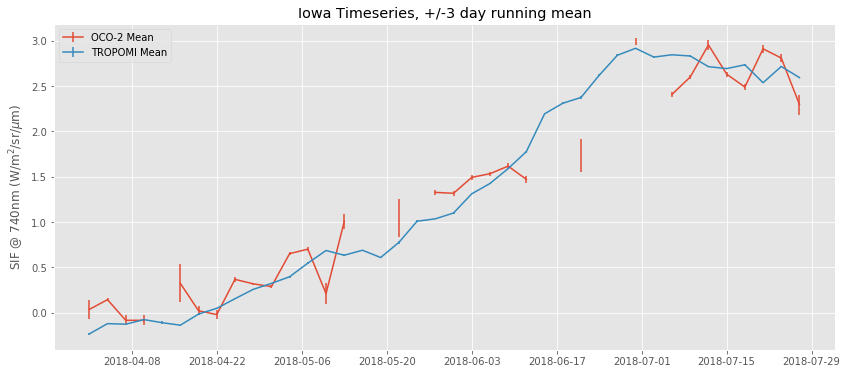

In [22]:
# Conversion factor from 758nm to 740nm is roughly 1.55 (we can provide shapes if needed)
cf = 1.55
plt.errorbar(dates, iowa_timeseries_oco2.mean*1.55,yerr=iowa_timeseries_oco2.standard_error*1.55, label='OCO-2 Mean')
plt.errorbar(dates, iowa_timeseries_tropomi.mean,yerr=iowa_timeseries_tropomi.standard_error,  label='TROPOMI Mean')
plt.ylabel('SIF @ 740nm (W/m$^2$/sr/$\mu$m)')
plt.legend(loc=0)
plt.title('Iowa Timeseries, +/-3 day running mean')

Text(0.5,1,'Length of Day correction impact')

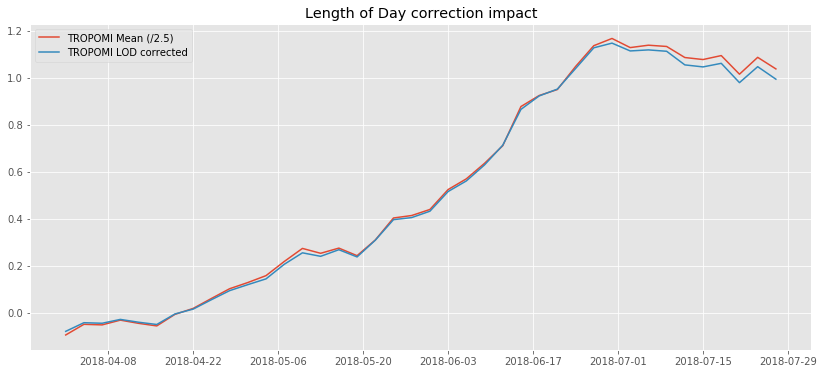

In [23]:
plt.plot(dates, iowa_timeseries_tropomi.mean/2.5, label='TROPOMI Mean (/2.5)')
plt.plot(dates, iowa_timeseries_tropomiDC.mean, label='TROPOMI LOD corrected')
plt.legend()
plt.title('Length of Day correction impact')

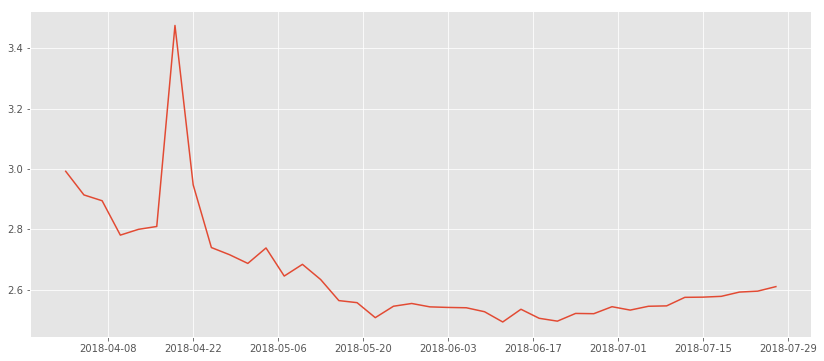

In [24]:
plt.plot(dates, iowa_timeseries_tropomi.mean/iowa_timeseries_tropomiDC.mean, label='TROPOMI Mean')

In [26]:
shape_scope = np.loadtxt('sif_shape_scope.dat')
shape_walz = np.loadtxt('PC1_SIFSpectra_allSpecies.dat')

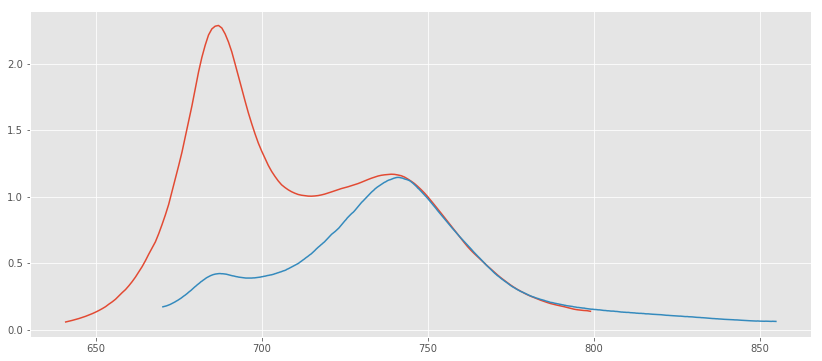

In [30]:
plt.plot(shape_scope[:,0], shape_scope[:,1])
plt.plot(shape_walz[:,0], shape_walz[:,1]*12)

In [45]:
from scipy.interpolate import interp1d
def convertWL(wl_in,wl_out,shape):
	f = interp1d(shape[:,0], shape[:,1],kind='cubic', bounds_error=False)
	return f(wl_out)/f(wl_in)

In [46]:
print(convertWL(758,740,shape_scope))
print(convertWL(758,740,shape_walz))

1.55323290161
1.52591251922


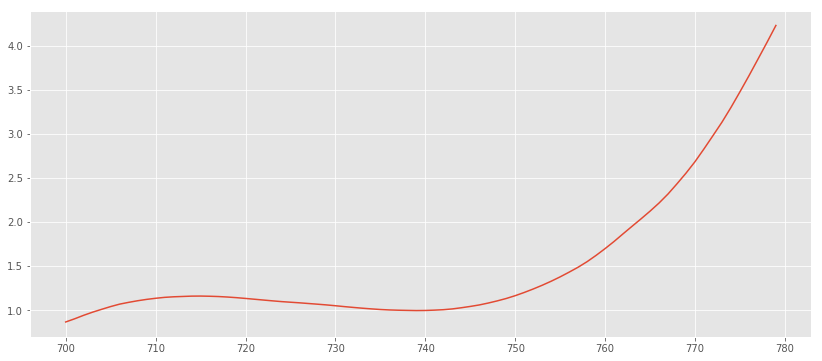

In [51]:
plt.plot(np.arange(700,780,1),convertWL(np.arange(700,780,1),740,shape_scope))